In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

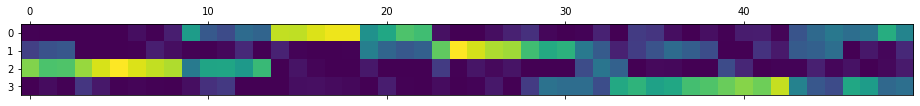

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(50, 40, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

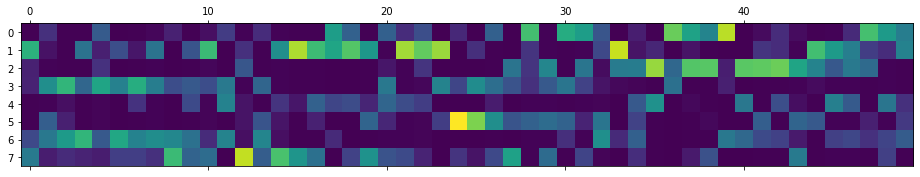

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

# Run CAVI

In [26]:
# get beta parameters for sticks and populations
ez_opt, vb_opt_dict, _, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 200,
                        f_tol = 1e-4)


iteration [1]; kl:3565.380166; elapsed: 0.0936secs
iteration [2]; kl:3561.581867; elapsed: 0.0271secs
iteration [3]; kl:3557.856543; elapsed: 0.0212secs
iteration [4]; kl:3554.210767; elapsed: 0.0146secs
iteration [5]; kl:3550.656565; elapsed: 0.0141secs
iteration [6]; kl:3547.209401; elapsed: 0.0175secs
iteration [7]; kl:3543.88581; elapsed: 0.0158secs
iteration [8]; kl:3540.701012; elapsed: 0.0151secs
iteration [9]; kl:3537.666957; elapsed: 0.0139secs
iteration [10]; kl:3534.79117; elapsed: 0.0126secs
iteration [11]; kl:3532.076608; elapsed: 0.0112secs
iteration [12]; kl:3529.522319; elapsed: 0.0106secs
iteration [13]; kl:3527.124361; elapsed: 0.0101secs
iteration [14]; kl:3524.876363; elapsed: 0.0104secs
iteration [15]; kl:3522.769444; elapsed: 0.0108secs
iteration [16]; kl:3520.791749; elapsed: 0.0163secs
iteration [17]; kl:3518.928218; elapsed: 0.0143secs
iteration [18]; kl:3517.161115; elapsed: 0.0166secs
iteration [19]; kl:3515.471296; elapsed: 0.0257secs
iteration [20]; kl:3513

iteration [161]; kl:3445.804805; elapsed: 0.0132secs
iteration [162]; kl:3445.444946; elapsed: 0.0118secs
iteration [163]; kl:3445.028464; elapsed: 0.0102secs
iteration [164]; kl:3444.545117; elapsed: 0.01secs
iteration [165]; kl:3443.984444; elapsed: 0.01secs
iteration [166]; kl:3443.337291; elapsed: 0.0107secs
iteration [167]; kl:3442.598472; elapsed: 0.0107secs
iteration [168]; kl:3441.770767; elapsed: 0.0163secs
iteration [169]; kl:3440.869779; elapsed: 0.0123secs
iteration [170]; kl:3439.927919; elapsed: 0.0109secs
iteration [171]; kl:3438.994355; elapsed: 0.01secs
iteration [172]; kl:3438.12767; elapsed: 0.0135secs
iteration [173]; kl:3437.381149; elapsed: 0.01secs
iteration [174]; kl:3436.786248; elapsed: 0.01secs
iteration [175]; kl:3436.343404; elapsed: 0.0101secs
iteration [176]; kl:3436.026372; elapsed: 0.0124secs
iteration [177]; kl:3435.797612; elapsed: 0.0102secs
iteration [178]; kl:3435.624067; elapsed: 0.0111secs
iteration [179]; kl:3435.483889; elapsed: 0.0181secs
iter

In [27]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [28]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, use_logitnormal_sticks = False)


In [29]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [30]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.00719sec


In [31]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.0221sec


In [32]:
# if its impossible, don't run the hessian
run_hessian = True

In [33]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 19.8sec


In [34]:
t0 = time.time()
hvp = obj_fun_hvp(vb_opt, prior_params_free, vb_opt)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.0292sec


In [35]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [36]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 0.602sec


# Solver times

In [37]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

LinAlgError: 1303-th leading minor of the array is not positive definite

In [ ]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

In [ ]:
t0 = time.time()
preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

In [ ]:
cg_solver_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))